# Assembly kmer estimates

We wish to the following properties of a genome based on the kmer histogram. Formally, we have as our input:

- $K_i$, where $i = 1..100001$, as the number of kmers at coverage $i$

We want to infer:

- $G_i$, where $i = 1..100$, as the number of kmers with copy number of $i$ in the genome sequence

This $G_i$ spectrum is interesting since it allows us to estimate

- Genome size $g = \sum_{i=1}^{100}{i * G_i}$

- Ploidy $p$ where $\sum_{i=1}^{p}{G_i} > 0.95 * \sum_{i=1}^{100}{G_i}$, i.e. with this ploidy you can explain most of the unique kmers in the genome

- Repeat contents $R = \sum_{i=p}^{100}{i * G_i} / \sum_{i=1}^{100}{i * G_i}$, ratio of all high copy kmers (larger than ploidy $p$) over all genome kmers

- Heterozygosity. Formula TBD.

$G_i$ can generate the expected $K_i$ which we can use to match to the observed $K_i$. The objective function can be minimize the K-L divergence.

- $D_{KL}(P | Q)$, where $P$ is the observed $K_i$ and $Q$ is the expected $K_i$, which is the amount of information lost when $Q$ is used to approximate $P$.

In [35]:
%matplotlib inline
import seaborn as sns
sns.set_context("talk")
import matplotlib.pyplot as plt
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

11:35:26 [pyplot] Loaded backend module://ipykernel.pylab.backend_inline version unknown.


## Sequencing error and PCR duplicates

Assume we have a kmer that has a small error rate $\epsilon$ to generate an erroneous kmer when duplicating. We simulate 8 rounds of PCR.

In [69]:
from random import choice, random
from jcvi.formats.fasta import rc

def generate_kmer(K=21):
    s = ''.join([choice('ATCG') for x in range(K)])
    return min(s, rc(s))

def mutate_kmer(kmer, mu=0.01):
    s = ''.join([(choice('ATCG') if random() < mu else k) for k in kmer])
    return min(s, rc(s))

def evolve(kmer, mu=0.01, start_coverage=1, end_coverage=30):
    pool = [kmer] * start_coverage
    while len(pool) < end_coverage:
        pool += [mutate_kmer(kmer, mu=mu) for kmer in pool]
    return pool[:end_coverage]
        
def summarize(pool):
    from collections import Counter
    for k, v in Counter(pool).items():
        print(k, v)

In [9]:
starting_kmer = generate_kmer()
for i in range(10):
    dup_kmer = mutate_kmer(starting_kmer)
    if dup_kmer == starting_kmer:
        print(starting_kmer)
    else:
        print(starting_kmer, "=>", dup_kmer)

CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA => CTGCCCTGCTTTTATCCAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA


In [70]:
pool = evolve(starting_kmer)
summarize(pool)

CTGCCCTGCTTTTATACAACA 27
CTCCCCTGCTTTTATACAACA 2
CTACCCTGCTTTTATACAACA 1


Now we have a mutation model which takes two parameters: 

- $\mu$ probability of per-base error when duplicating
- $r$ PCR duplication round

In [71]:
from functools import lru_cache
from collections import Counter
import sys

@lru_cache(maxsize=None)
def sequencing_model(K=21, mu1000x=10, start_coverage=1, end_coverage=30):
    N = 10000
    diff = Counter()
    same = Counter()
    total = 0
    for _ in range(N):
        if i % 100 == 0: print("Sample", i, file=sys.stderr)
        starting_kmer = generate_kmer(K=K)
        pool = evolve(starting_kmer, mu=mu1000x/1000, start_coverage=start_coverage, end_coverage=end_coverage)
        for pkmer, v in Counter(pool).items():
            if pkmer == starting_kmer:
                same[v] += 1
            else:
                diff[v] += 1
            total += v
    return same, diff, total

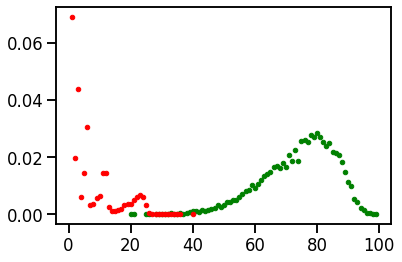

In [74]:
mm_same, mm_diff, mm_total = sequencing_model(mu1000x=8, start_coverage=2, end_coverage=100)

x, y = zip(*mm_same.items())
z = [_x * _y / mm_total for _x, _y in zip(x, y)]
plt.plot(x, z, ".", color='g')

x, y = zip(*mm_diff.items())
z = [_x * _y / mm_total for _x, _y in zip(x, y)]
plt.plot(x, z, ".", color='r')